In [63]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [64]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [65]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [66]:
# create engine to hawaii.sqlite
database_path = "Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}")

In [67]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [68]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [69]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [70]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [71]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [72]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
min_avg_max = calc_temps('2016-08-23', '2017-08-23')
min_avg_max

[(58.0, 74.59058295964125, 87.0)]

In [73]:
one_year_data = calc_temps('2016-08-23','2017-08-23') 
tmin = one_year_data[0][0]
tmax = one_year_data[0][1]
tavg = one_year_data[0][2]
error = tmax - tmin 


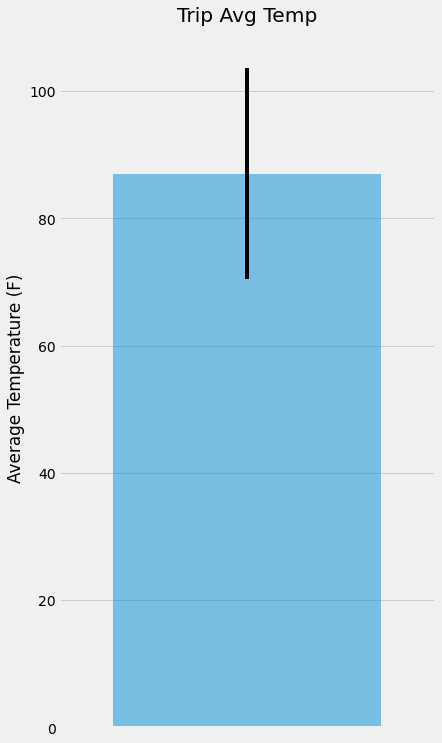

<Figure size 432x288 with 0 Axes>

In [74]:
fig, ax = plt.subplots(figsize=(6,12))
bar = ax.bar(xpos, tavg, yerr=error, alpha=0.5, )
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Average Temperature (F)")
ax.margins(.2, .2)
plt.ylim(0,110)
plt.savefig('Trip Avg Temperature Bar Graph.png')
plt.show()
plt.tight_layout()

In [75]:
# As a practice, tried to query, 
#Set each variable for start and end date 
# start = '2016-08-23'
# end = '2017-08-23'

# #Query 
# year_query = session.query(Measurement.date, Measurement.tobs).\
#         filter(Measurement.date >= start).filter(Measurement.date <= end).all()

#Convert the results into DataFrame
# year_temperature = pd.DataFrame(year_query, columns=['date', 'tobs'])

# Check to see if the min, max and avg temp are correct.
# year_temperature.describe()

#tmax = year_temperature['tobs'].max()
#tmin = year_temperature['tobs'].min()
#error = tmax - tmin

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr) 
#Calculate the error 

# avg_temp = year_temperature.mean()
# error = tmax - tmin 

# avg_temp.plot(legend=False,kind="bar",color="orange",yerr=error, width=0.1, figsize=(12,6))
# plt.title("Trip Avg Temperature")
# plt.ylabel("Temperature(°F)")
# plt.ylim(0,110)
# plt.savefig('Trip Avg Temperature Bar Graph.png')
# plt.show()

### Daily Rainfall Average

In [76]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_start_date = '2017-08-01'
trip_end_date = '2017-08-07'

query_results = session.query(Station.station, func.sum(Measurement.prcp), Station.name, Station.elevation,Station.latitude,Station.longitude).\
    filter(Measurement.station == Station.station).filter(Measurement.date >= trip_start_date).filter(Measurement.date <= trip_end_date).\
    group_by(Station.station).order_by(func.sum(Measurement.prcp).desc())

query_results.all()

for x in query_results:
    print(f'Location: {x[2]}\n Station: {x[0]}\n Rainfall: {x[1]}\n Elevation: {x[3]}\n Latitude: {x[4]}\n Longitude: {x[5]}\n')
    
    

Location: MANOA LYON ARBO 785.2, HI US
 Station: USC00516128
 Rainfall: 0.36
 Elevation: 152.4
 Latitude: 21.3331
 Longitude: -157.8025

Location: KUALOA RANCH HEADQUARTERS 886.9, HI US
 Station: USC00514830
 Rainfall: 0.22
 Elevation: 7.0
 Latitude: 21.5213
 Longitude: -157.8374

Location: WAIHEE 837.5, HI US
 Station: USC00519281
 Rainfall: 0.06
 Elevation: 32.9
 Latitude: 21.45167
 Longitude: -157.84888999999998

Location: WAIKIKI 717.2, HI US
 Station: USC00519397
 Rainfall: 0.04
 Elevation: 3.0
 Latitude: 21.2716
 Longitude: -157.8168

Location: WAIMANALO EXPERIMENTAL FARM, HI US
 Station: USC00519523
 Rainfall: 0.0
 Elevation: 19.5
 Latitude: 21.33556
 Longitude: -157.71139



In [77]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [78]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

one_year_data = calc_temps('2017-08-01','2017-08-01') 
# tmin = one_year_data[0][0]
# tmax = one_year_data[0][1]
# tavg = one_year_data[0][2]
# Use the start and end date to create a range of dates
ranged_dates_df = pd.date_range(start_date,end_date).tolist()
ranged_dates_df

[Timestamp('2017-08-01 00:00:00', freq='D'),
 Timestamp('2017-08-02 00:00:00', freq='D'),
 Timestamp('2017-08-03 00:00:00', freq='D'),
 Timestamp('2017-08-04 00:00:00', freq='D'),
 Timestamp('2017-08-05 00:00:00', freq='D'),
 Timestamp('2017-08-06 00:00:00', freq='D'),
 Timestamp('2017-08-07 00:00:00', freq='D')]

In [79]:
normals = []
delta = dt.datetime.strptime(end_date, "%Y-%m-%d") - dt.datetime.strptime(start_date, "%Y-%m-%d")
dates = []
for i in range(delta.days+1):
    date = dt.datetime.strptime(start_date, "%Y-%m-%d") + dt.timedelta(days=i)
    dates.append(dt.datetime.strftime(date, "%Y-%m-%d"))
    tmin,tavg,tmax = np.ravel(daily_normals(dt.datetime.strftime(date, "%m-%d")))
    normals.append((tmin,tavg,tmax))

In [80]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'], index=dates)  

In [81]:
# # push each tuple of calculations into a list called `normals`
# # My trip dates again are: '02-22' Through'03-01'
# trip_dates = ['08-01','08-02','08-03','08-04','08-05','08-06','08-07']

# # push each tuple of calculations into a list called `normals`
# # start with a blank list named normals
# normals =[]

# #Set the start and end date of the trip
# # Use 'date' function to return the date without a time for our vacation start
# start_vacation = dt.date(2017,8,1)
# # Store the number of days of the vacation
# numdays = 7

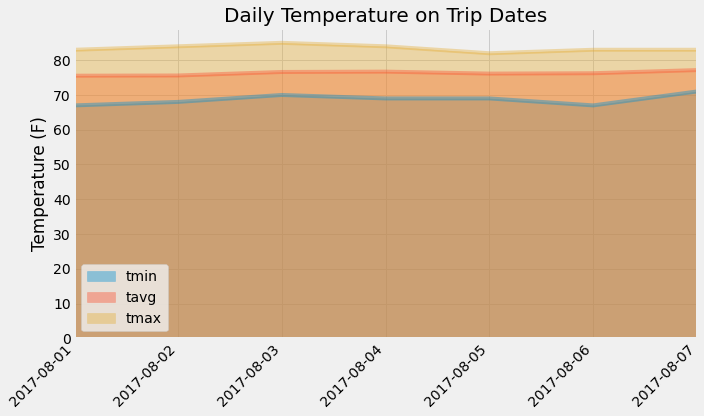

In [82]:
# Strip off the year and save a list of strings in the format %m-%d
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots(figsize=(10,6))
normals_DF.plot.area(ax=ax, stacked=False, alpha=0.4)
plt.xticks(range(len(dates)), dates, rotation=45, ha='right')
plt.xlim((0,len(dates)-1))
plt.ylabel("Temperature (F)")
plt.title(f"Daily Temperature on Trip Dates", fontsize=20, y=1)
plt.tight_layout()
plt.savefig('Daily Temperature on Trip Date')

## Close Session

In [22]:
session.close()